In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from scipy.stats import norm, skew #for some statistics
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import lightgbm as lgb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.wrappers.scikit_learn import KerasRegressor
from scipy.special import boxcox1p

import itertools
import math
from scipy import stats

%matplotlib inline

# pd.set_option("display.max_rows", 10)

np.random.seed(2)

Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [3]:
train = train.drop('Id', axis=1)
train.columns


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [4]:
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


# TODO:
    * Remove outliers
    * Fill missing data with modes calculated for similar data

# Filling NaNs

## TODO: spend some more time on these columns

In [5]:
cols_with_none_as_nan = [
    "PoolQC", 
    "MiscFeature", 
    "Alley", 
    "Fence", 
    "FireplaceQu", 
    'GarageType', 
    'GarageFinish', 
    'GarageQual', 
    'GarageCond', 
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'Electrical', 
    'BsmtFinType1', 
    'BsmtFinType2', 
    "MasVnrType",
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'KitchenQual',
    'Functional',
    'SaleType']


# fill missing text fields with a default string
object_columns = train.select_dtypes(include=[object])
test_object_columns = test.select_dtypes(include=[object])

# for these colunms the string 'None' will be inserted in place of nan
for col in cols_with_none_as_nan:
    object_columns.loc[:, col] = object_columns.loc[:, col].fillna('None')
    test_object_columns.loc[:, col] = test_object_columns.loc[:, col].fillna('None')

remaining_fix = object_columns.isnull().sum()
print('Fixes remaining on train set\n', remaining_fix[remaining_fix>0])

remaining_fix = test_object_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

/home/daniele/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Fixes remaining on train set
 Series([], dtype: int64)
Fixes remaining on test set
 Series([], dtype: int64)


In [6]:
int_columns = train.select_dtypes(include=[int, float])

remaining_fix = int_columns.isnull().sum()
print('Fixes remaining on train set\n',remaining_fix[remaining_fix>0])

test_int_columns = test.select_dtypes(include=[int, float])

remaining_fix = test_int_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

Fixes remaining on train set
 LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64
Fixes remaining on test set
 LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      78
GarageCars        1
GarageArea        1
dtype: int64


In [7]:
cols_with_zero_as_nan = ['MasVnrArea', 
                         'GarageYrBlt',
                         'BsmtFinSF1',
                         'BsmtFinSF2',
                         'BsmtUnfSF',
                         'TotalBsmtSF',
                         'BsmtFullBath',
                         'BsmtHalfBath',
                         'GarageCars',
                         'GarageArea',
                        ]
cols_with_mean_as_nan = ['LotFrontage']

# for these colunms the mean will be inserted in place of nan
for col in cols_with_mean_as_nan:
    int_columns.loc[:, col] = int_columns.loc[:, col].fillna(int_columns[col].mean())
    test_int_columns.loc[:, col] = test_int_columns.loc[:, col].fillna(test_int_columns[col].mean())

# for these colunms a zero will be inserted in place of nan
for col in cols_with_zero_as_nan:
    int_columns.loc[:, col] = int_columns.loc[:, col].fillna(0)
    test_int_columns.loc[:, col] = test_int_columns.loc[:, col].fillna(0)


remaining_fix = int_columns.isnull().sum()
print('Fixes remaining on train set\n',remaining_fix[remaining_fix>0])

remaining_fix = test_int_columns.isnull().sum()
print('Fixes remaining on test set\n',remaining_fix[remaining_fix>0])

/home/daniele/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Fixes remaining on train set
 Series([], dtype: int64)
Fixes remaining on test set
 Series([], dtype: int64)


# Outliers

Found outliers for  LotArea
At row 249 found value 159000:
At row 313 found value 215245:
At row 335 found value 164660:
At row 706 found value 115149:


/home/daniele/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


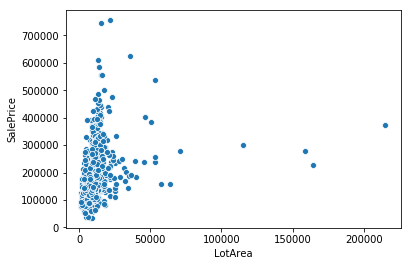

Found outliers for  BsmtFinSF1
At row 1298 found value 5644:


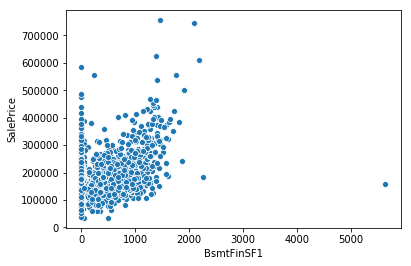

Found outliers for  TotalBsmtSF
At row 1298 found value 6110:


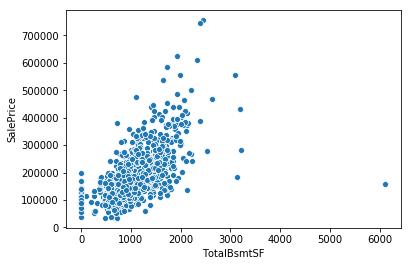

Found outliers for  LowQualFinSF
At row 88 found value 513:
At row 170 found value 528:
At row 185 found value 572:
At row 635 found value 515:
At row 1009 found value 514:


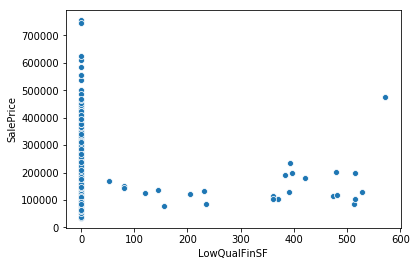

Found outliers for  3SsnPorch
At row 5 found value 320:
At row 55 found value 407:
At row 205 found value 508:
At row 1437 found value 304:


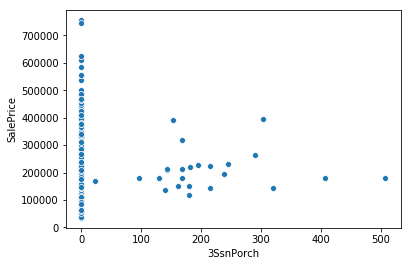

Found outliers for  PoolArea
At row 197 found value 512:
At row 810 found value 648:
At row 1170 found value 576:
At row 1182 found value 555:
At row 1298 found value 480:
At row 1386 found value 519:
At row 1423 found value 738:


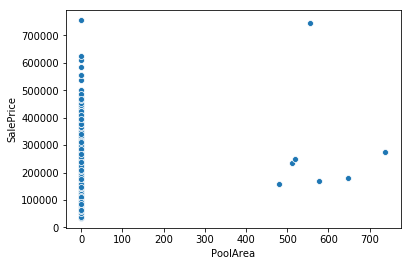

Found outliers for  MiscVal
At row 346 found value 15500:
At row 1230 found value 8300:


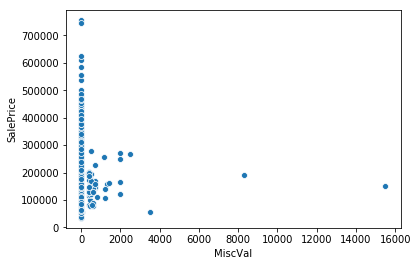

In [8]:
threshold = 10

for c in int_columns.columns:
    df = pd.DataFrame(train[c])
    df['SalePrice'] = train['SalePrice']
    z = np.abs(stats.zscore(df.values))
    z = np.where(z > threshold)
    if len(z[0]) > 0:
        print('Found outliers for ', c)
        for i in z[0]:
            print('At row {} found value {}:'.format(i, int_columns[c][i]))
        sns.scatterplot(x=df[c], y=df['SalePrice'])
        plt.show()


In [9]:
# Removing:
# Found outliers for  MiscVal
# At row 346 found value 15500:
# Found outliers for  LotArea
# At row 249 found value 159000:

outliers_to_remove = [346, 249]

# Features skewness
## TODO understand why skewness correction gives worse results

In [10]:
skewed_feats = int_columns.apply(lambda x: abs(skew(x.dropna()))).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness = skewness[abs(skewness) > 0.75].dropna()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

print("\nSkew > .75 in numerical features: \n")
print(skewness)

# Fix skewness
skewed_features = skewness.index
lam = 0.15
#for feat in skewed_features:
#    if feat == 'SalePrice': continue
#    int_columns[feat] = boxcox1p(int_columns[feat], lam)


There are 23 skewed numerical features to Box Cox transform

Skew > .75 in numerical features: 

                    Skew
MiscVal        24.451640
PoolArea       14.813135
LotArea        12.195142
3SsnPorch      10.293752
LowQualFinSF    9.002080
KitchenAbvGr    4.483784
BsmtFinSF2      4.250888
ScreenPorch     4.117977
BsmtHalfBath    4.099186
GarageYrBlt     3.865524
EnclosedPorch   3.086696
MasVnrArea      2.674865
LotFrontage     2.382499
OpenPorchSF     2.361912
SalePrice       1.880941
BsmtFinSF1      1.683771
WoodDeckSF      1.539792
TotalBsmtSF     1.522688
MSSubClass      1.406210
1stFlrSF        1.375342
GrLivArea       1.365156
BsmtUnfSF       0.919323
2ndFlrSF        0.812194


# Enconding string columns with LabelEncoder

In [11]:

strings = np.array([])
for c in object_columns.columns:
    strings = np.append(strings, pd.unique(object_columns[c].values))

for c in test_object_columns.columns:
    strings = np.append(strings, pd.unique(test_object_columns[c].values))

print(len(strings), 'distinct labels generated')

labeler = LabelEncoder()
labeler.fit(strings)

for c in object_columns.columns:
    object_columns.loc[:,c] = labeler.transform(object_columns.loc[:,c])
    test_object_columns.loc[:,c] = labeler.transform(test_object_columns.loc[:,c])

object_columns[0:5]

522 distinct labels generated


MSZoning  Street  Alley  LotShape  LandContour  Utilities  LotConfig  \
0       133     126    114       140           89         12         87   
1       133     126    114       140           89         12         54   
2       133     126    114        83           89         12         87   
3       133     126    114        83           89         12         47   
4       133     126    114        83           89         12         54   

   LandSlope  Neighborhood  Condition1      ...        GarageType  \
0         78            41         115      ...                17   
1         78           163          59      ...                17   
2         78            41         115      ...                17   
3         78            48         115      ...                50   
4         78           112         115      ...                17   

   GarageFinish  GarageQual  GarageCond  PavedDrive  PoolQC  Fence  \
0           131         155         155         173     114    114   
1           131         155         155         173     114    114   
2           131         155         155         173     114    114   
3           162         155         155         173     114    114   
4           131         155         155         173     114    114   

   MiscFeature  SaleType  SaleCondition  
0          114       165            116  
1          114       165            116  
2          114       165            116  
3          114       165             10  
4          114       165            116  

[5 rows x 43 columns]

# Assembling the datasets

In [12]:
# final train dataset
train_ds = object_columns.join(int_columns)
train_ds["SalePrice"] = np.log1p(train_ds["SalePrice"])

# test dataset
test_ds = test_object_columns.join(test_int_columns)

#correlation matrix
corrmat = train_ds.corr()['SalePrice']
#f, ax = plt.subplots(figsize=(12, 9))
#sns.heatmap(corrmat, vmax=.8, square=True);

best_columns = corrmat[abs(corrmat) > 0.0].index
train_ds = train_ds[best_columns]
test_ds = test_ds[best_columns.drop('SalePrice')]


In [13]:
X_train = (train_ds.values[:,:-1])
y_train = np.asarray([[t] for t in (train_ds.values[:,-1])])
X_test = test_ds.values

print('Training set features shape', X_train.shape)
print('Training set labels shape', y_train.shape)
print('Test set shape', test_ds.shape)


Training set features shape (1460, 79)
Training set labels shape (1460, 1)
Test set shape (1459, 79)


## Removing outliers

In [14]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X_train)
X_train = pd.DataFrame(transformer.transform(X_train))
X_test = pd.DataFrame(transformer.transform(X_test))

In [15]:
print('Training set features shape', X_train.shape)
print('Training set labels shape', y_train.shape)


Training set features shape (1460, 79)
Training set labels shape (1460, 1)


In [16]:
def train(depth, learning_rate, n_estimators, model_type='xgb'):
    if model_type == 'xgb':
        model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                 learning_rate=learning_rate, max_depth=depth, 
                                 min_child_weight=1.7817, n_estimators=n_estimators,
                                 reg_alpha=0.4640, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state =7, nthread = -1)
    if model_type == 'lgb':
        model = lgb.LGBMRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                 learning_rate=learning_rate, max_depth=depth, 
                                 min_child_weight=1.7817, n_estimators=n_estimators,
                                 reg_alpha=0.4640, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state =7, nthread = -1)
    score = rmsle_cv(model)
    print(model_type, " score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))
    return score

#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train.flatten(), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# Training: XGBoost
## TODO: brute_force in regularization parameters

In [17]:

result = []
for depth in range(4, 5):
    for learning_rate in range(3, 4, 1):
        for n_estimators in range(4400, 4600, 200):
            score = train(depth, learning_rate/100, n_estimators, model_type='xgb')
            result.append([depth, learning_rate/100, n_estimators, score.mean(), score.std()])


xgb  score: depth=4 lr=0.03 est=4400 -> mean:0.12207 std:0.0096


In [18]:
# check results
result = pd.DataFrame(result, columns=['depth', 'learning_rate', 'n_estimators', 'score_mean', 'score_std'])
result.describe()


depth  learning_rate  n_estimators  score_mean  score_std
count    1.0           1.00           1.0    1.000000   1.000000
mean     4.0           0.03        4400.0    0.122068   0.009581
std      NaN            NaN           NaN         NaN        NaN
min      4.0           0.03        4400.0    0.122068   0.009581
25%      4.0           0.03        4400.0    0.122068   0.009581
50%      4.0           0.03        4400.0    0.122068   0.009581
75%      4.0           0.03        4400.0    0.122068   0.009581
max      4.0           0.03        4400.0    0.122068   0.009581

In [19]:
best = np.argmin(result['score_mean'].values)
print('Best try = \n', result.iloc[best])


Best try = 
 depth               4.000000
learning_rate       0.030000
n_estimators     4400.000000
score_mean          0.122068
score_std           0.009581
Name: 0, dtype: float64


* Best try = 
* depth               4.000000
* learning_rate       0.030000
* n_estimators     4400.000000
* score_mean          0.122068
* score_std           0.009581


In [20]:
# train with the best parameters
depth = int(result.iloc[best]['depth'])
learning_rate = result.iloc[best]['learning_rate']
n_estimators = int(result.iloc[best]['n_estimators'])

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                         learning_rate=learning_rate, max_depth=depth, 
                         min_child_weight=1.7817, n_estimators=n_estimators,
                         reg_alpha=0.4640, reg_lambda=0.8571,
                         subsample=0.5213, silent=1,
                         random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_train)
print('RMSLE XGB = ', rmsle(y_train, y_pred))


Xgboost score: depth=4 lr=0.03 est=4400 -> mean:0.12207 std:0.0096
RMSLE XGB =  0.07584312944985448


* Xgboost score: depth=4 lr=0.03 est=4400 -> mean:0.12207 std:0.0096
* RMSLE XGB =  0.07584312944985448


(1460, 1)
(1460, 1)
(1460,)


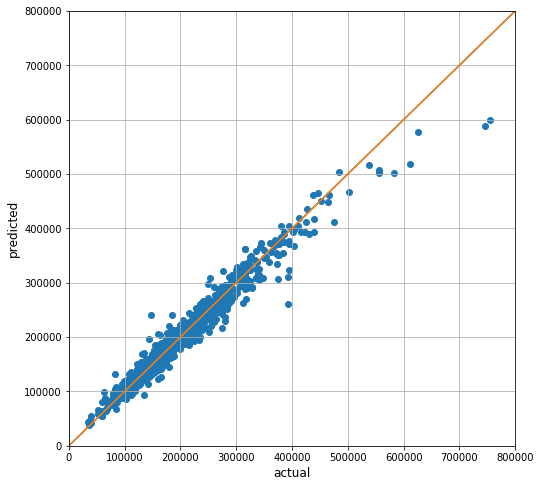

In [21]:
plt.figure(figsize=(8, 8))
y_pred = model_xgb.predict(X_train)
print(y_train.shape)
print(y_train.shape)
print(y_pred.shape)
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 800_000)
plt.ylim(0, 800_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.grid()
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()


# Training: lightgbm
## TODO: brute_force in regularization parameters

In [22]:
result = []
for depth in range(4, 6):
    for learning_rate in range(2, 3, 1):
        for n_estimators in range(1200, 2000, 200):
            score = train(depth, learning_rate/100, n_estimators, model_type='lgb')
            result.append([depth, learning_rate/100, n_estimators, score.mean(), score.std()])


lgb  score: depth=4 lr=0.02 est=1200 -> mean:0.12649 std:0.0110
lgb  score: depth=4 lr=0.02 est=1400 -> mean:0.12642 std:0.0110
lgb  score: depth=4 lr=0.02 est=1600 -> mean:0.12639 std:0.0110
lgb  score: depth=4 lr=0.02 est=1800 -> mean:0.12640 std:0.0110
lgb  score: depth=5 lr=0.02 est=1200 -> mean:0.12647 std:0.0113
lgb  score: depth=5 lr=0.02 est=1400 -> mean:0.12646 std:0.0113
lgb  score: depth=5 lr=0.02 est=1600 -> mean:0.12647 std:0.0113
lgb  score: depth=5 lr=0.02 est=1800 -> mean:0.12647 std:0.0113


In [23]:
# check results
result = pd.DataFrame(result, columns=['depth', 'learning_rate', 'n_estimators', 'score_mean', 'score_std'])
result.describe()


depth  learning_rate  n_estimators  score_mean  score_std
count  8.000000           8.00      8.000000    8.000000   8.000000
mean   4.500000           0.02   1500.000000    0.126446   0.011134
std    0.534522           0.00    239.045722    0.000038   0.000152
min    4.000000           0.02   1200.000000    0.126387   0.010963
25%    4.000000           0.02   1350.000000    0.126418   0.011005
50%    4.500000           0.02   1500.000000    0.126463   0.011147
75%    5.000000           0.02   1650.000000    0.126470   0.011274
max    5.000000           0.02   1800.000000    0.126492   0.011281

In [24]:
best = np.argmin(result['score_mean'].values)
print('Best try = \n', result.iloc[best])


Best try = 
 depth               4.000000
learning_rate       0.020000
n_estimators     1600.000000
score_mean          0.126387
score_std           0.010963
Name: 2, dtype: float64


# Best try = 
* Best try = 
* depth               4.000000
* learning_rate       0.020000
* n_estimators     1600.000000
* score_mean          0.126387
* score_std           0.010963


In [25]:
# train with the best parameters
depth = int(result.iloc[best]['depth'])
learning_rate = result.iloc[best]['learning_rate']
n_estimators = int(result.iloc[best]['n_estimators'])

model_lgb = lgb.LGBMRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                         learning_rate=learning_rate, max_depth=depth, 
                         min_child_weight=1.7817, n_estimators=n_estimators,
                         reg_alpha=0.4640, reg_lambda=0.8571,
                         subsample=0.5213, silent=1,
                         random_state =7, nthread = -1)


score = rmsle_cv(model_lgb)
print("lgb score: depth={:d} lr={:.2f} est={:d} -> mean:{:.5f} std:{:.4f}".format(depth, learning_rate, n_estimators, score.mean(), score.std()))

model_lgb.fit(X_train, y_train.flatten())
y_pred = model_lgb.predict(X_train)

print('RMSLE LGB = ', rmsle(y_train, y_pred))


lgb score: depth=4 lr=0.02 est=1600 -> mean:0.12639 std:0.0110
RMSLE LGB =  0.05778702152750832


* lgb score: depth=4 lr=0.02 est=1600 -> mean:0.12639 std:0.0110
* RMSLE LGB =  0.05778702152750832


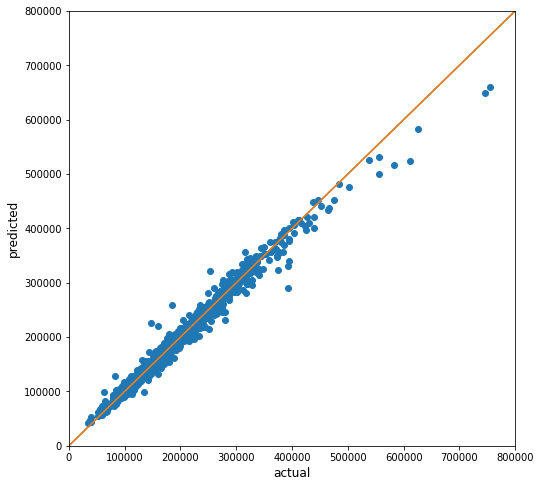

In [26]:

plt.figure(figsize=(8, 8))
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 800_000)
plt.ylim(0, 800_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()


# Averaged model

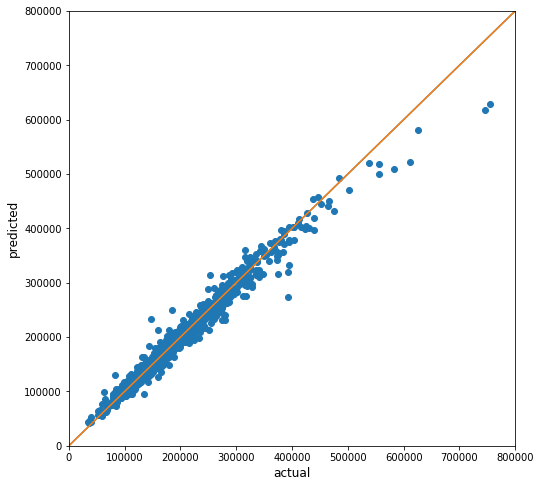

RMSLE LGB =  0.06539346038526068


In [27]:
avg_predict = (model_lgb.predict(X_train) + model_xgb.predict(X_train)) / 2
y_pred = avg_predict

plt.figure(figsize=(8, 8))
plt.scatter(np.expm1(y_train), np.expm1(y_pred))
plt.xlim(0, 800_000)
plt.ylim(0, 800_000)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (1_000_000, 1_000_000)], [(0, 0), (1_000_000, 1_000_000)])
plt.show()

print('RMSLE LGB = ', rmsle(y_train, y_pred))



# Target: RMSLE LGB =  0.06539346038526068


In [28]:
# Submission
print(np.expm1(model_xgb.predict(X_test)[0:5]))
print(np.expm1(model_lgb.predict(X_test)[0:5]))
avg_predict = (model_xgb.predict(X_test) + model_lgb.predict(X_test)) / 2
subm_predict = np.expm1(avg_predict)

dsubm_predict = pd.DataFrame(subm_predict)
dsubm_predict['Id'] = test.values[:,0]
dsubm_predict.columns = ['SalePrice', 'Id']

dsubm_predict.to_csv('submission.csv', index=False)
dsubm_predict[0:10]


[126361.51 162378.14 178397.12 190489.61 193738.12]
[123887.33541152 164023.22115662 183230.1810325  194578.69917697
 187706.1106765 ]


SalePrice    Id
0  125118.305690  1461
1  163198.607503  1462
2  180797.508238  1463
3  192523.297599  1464
4  190698.264923  1465
5  173990.886434  1466
6  178544.385778  1467
7  166076.191655  1468
8  174959.774185  1469
9  127019.765216  1470

# Score on kaggle: 0.12276